### Preprocessing
Inspired by DSCC_Net

#### Imports

In [ ]:
import kagglehub
import os
import pathlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import cv2
import numpy as np
import math
from imblearn.combine import SMOTETomek

#### Download ISIC-2019

In [4]:
# Download latest version
base_path_isic = kagglehub.dataset_download("andrewmvd/isic-2019")
print("Base path to ISIC-2019:", base_path_isic)

Base path to ISIC-2019: /Users/audreylu/.cache/kagglehub/datasets/andrewmvd/isic-2019/versions/1


#### Download HAM10000

In [3]:
# Download latest version
base_path_ham = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")
print("Base path to HAM10000:", base_path_ham)

100%|██████████| 5.20G/5.20G [02:30<00:00, 37.0MB/s]

Extracting model files...


Base path to HAM10000: /Users/audreylu/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2


#### Filter Functions
Hair Removal and Noise Reduction

In [ ]:
def filter_all_images(input_folder: str, output_folder: str) -> None:
    """Apply all filtering functions to jpg files in input_folder."""
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    for file_name in os.listdir(input_folder):
        try:
            if file_name.endswith(".jpg"):
                print(f"Processing {file_name}...")
                if not os.path.exists(os.path.join(output_folder, file_name)):
                    filter_image(input_folder, output_folder, file_name)
                else:
                    print(f"{file_name} already exists in {output_folder}. Skipping.")
        except Exception as e:
            print(f"Error processing image {file_name}: {e}")

def filter_image(input_folder: str, output_folder: str, file_name: str) -> None:
    """Apply all filtering functions to a single image file."""
    image_path = os.path.join(input_folder, file_name)
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error loading image from {image_path}")
    else:
        image_hr = hair_removal(image)
        image_nr = noise_reduction(image_hr)

        image_final = image_nr
        output_path = os.path.join(output_folder, file_name)
        cv2.imwrite(output_path, image_final)

def hair_removal(image: np.ndarray) -> np.ndarray:
    """Apply hair removal filter to the image using the Dull Razor algorithm."""
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))  # creates a kernel for morphing
    blackhat = cv2.morphologyEx(gray_image, cv2.MORPH_BLACKHAT, kernel)  # apply blackhat filter (highlights dark regions)
    bhg = cv2.GaussianBlur(blackhat, (9, 9), cv2.BORDER_REPLICATE)  # smooths image
    _, mask = cv2.threshold(bhg, 50, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)  # creates a binary mask to detect hair-like structure
    inpainted_image = cv2.inpaint(image, mask, 4, cv2.INPAINT_TELEA)
    return inpainted_image

def noise_reduction(image: np.ndarray) -> np.ndarray:
    """Apply noise reduction to the image using Median Filtering and Bilateral Filtering."""
    image_mf = cv2.medianBlur(image, 5)  # Apply median filter to reduce salt and pepper noise
    image_bf = cv2.bilateralFilter(image_mf, d=17, sigmaColor=100, sigmaSpace=100)  # Apply bilateral filter to reduce noise while preserving edges
    return image_bf

#### Preprocessing Functions
SMOTE-Tomek Oversampling

In [ ]:
def oversample_melanoma_images(output_folder: str, data_frame: pd.DataFrame, output_csv_path: str, image_size=(224, 224)) -> None:
    """
    Oversample melanoma images using SMOTE-Tomek.

    output_folder: Path to the folder with filtered images and where upsampled images will be saved.
    data_frame: DataFrame containing image file names, melanoma (0 or 1), and paths.
    output_csv_path: Path to save the updated CSV file.
    image_size: Target size (width, height) for resized images.
    """
    # Load melanoma images and their labels
    melanoma_df = data_frame[data_frame['melanoma'] == 1]
    non_melanoma_df = data_frame[data_frame['melanoma'] == 0]

    melanoma_images = []
    melanoma_labels = []

    for image_path in melanoma_df['path']:
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Load as RGB
        if image is not None:
            resized_image = cv2.resize(image, image_size)  # Resize to target size
            melanoma_images.append(resized_image.flatten())  # Flatten the image
            melanoma_labels.append(1)  # Label for melanoma

    non_melanoma_images = []
    non_melanoma_labels = []

    for image_path in non_melanoma_df['path']:
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Load as RGB
        if image is not None:
            resized_image = cv2.resize(image, image_size)  # Resize to target size
            non_melanoma_images.append(resized_image.flatten())  # Flatten the image
            non_melanoma_labels.append(0)  # Label for non-melanoma

    # Combine melanoma and non-melanoma data
    X = np.array(melanoma_images + non_melanoma_images)
    y = np.array(melanoma_labels + non_melanoma_labels)

    # Apply SMOTE-Tomek
    smote_tomek = SMOTETomek(random_state=42)
    X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

    synthetic_data = {"image_name": [], "melanoma": [], "path": []}
    for i, (image_data, label) in enumerate(zip(X_resampled, y_resampled)):
        reshaped_image = image_data.reshape(image_size[0], image_size[1], 3)  # Reshape to original size
        output_image_path = os.path.join(output_folder, f"synthetic_{i}.jpg")
        cv2.imwrite(output_image_path, reshaped_image)  # Save the image
        synthetic_data["image_name"].append(f"synthetic_{i}")
        synthetic_data["melanoma"].append(label)
        synthetic_data["path"].append(output_image_path)

    # Save the updated DataFrame
    synthetic_df = pd.DataFrame(synthetic_data)
    combined_df = pd.concat([data_frame, synthetic_df], ignore_index=True)
    combined_df.to_csv(output_csv_path)
    print(f"Updated CSV saved to {output_csv_path}")

    return combined_df

#### View Functions

In [8]:
def num_melanoma(data_frame: pd.DataFrame) -> int:
    # Count number of melanoma vs non-melanoma
    melanoma_count = data_frame[data_frame["melanoma"] == 1].shape[0]
    non_melanoma_count = data_frame[data_frame["melanoma"] == 0].shape[0]

    print(f"\nMelanoma images: {melanoma_count}")
    print(f"Non-Melanoma images: {non_melanoma_count}")

    # Percent distribution
    print("\nMEL column class distribution (%):")
    print(data_frame["melanoma"].value_counts(normalize=True) * 100)

def view_images(folder: str, num=None) -> None:
    """
    View a subset of images from the dataset.

    folder: Path to the folder containing images
    num: Number of images to display. If None, display all images in the folder.
    """
    image_files = [f for f in os.listdir(folder) if f.endswith('.jpg') and os.path.isfile(os.path.join(folder, f))]
    if num is None:
        num = len(image_files)
    n_rows = math.ceil(num / 5)
    n_cols = 5
    plt.figure(figsize=(n_cols * 3, n_rows * 5))  # Adjust figure size dynamically
    for i, image_file in enumerate(image_files[:num]):
        image_path = os.path.join(folder, image_file)
        img = mpimg.imread(image_path)
        
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(img)
        plt.title(image_file, fontsize=8)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

#### Path Setup

In [ ]:
isic_base_path = '/Users/audreylu/.cache/kagglehub/datasets/andrewmvd/isic-2019/versions/1'  # Update this path as needed
isic_folder = os.path.join(isic_base_path, 'ISIC_2019_Training_Input', 'ISIC_2019_Training_Input')
isic_labels_path = os.path.join(isic_base_path, 'ISIC_2019_Training_GroundTruth.csv')

ham_base_path = '/Users/audreylu/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2'  # Update this path as needed
ham_folder_1 = os.path.join(ham_base_path, 'HAM10000_images_part_1')
ham_folder_2 = os.path.join(ham_base_path, 'HAM10000_images_part_2')
ham_labels_path = os.path.join(ham_base_path, 'HAM10000_metadata.csv')

output_folder = '../../preprocessed_dataset'  # Update this path as needed
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
output_csv_path = '../../ISIC_HAM_Training_Balanced.csv'

#### View Images

ISIC 2019 images
Total .jpg files found: 25331
Sample image names: ['ISIC_0030858.jpg', 'ISIC_0030680.jpg', 'ISIC_0033389.jpg', 'ISIC_0032097.jpg', 'ISIC_0054312.jpg']

Images before preprocessing:


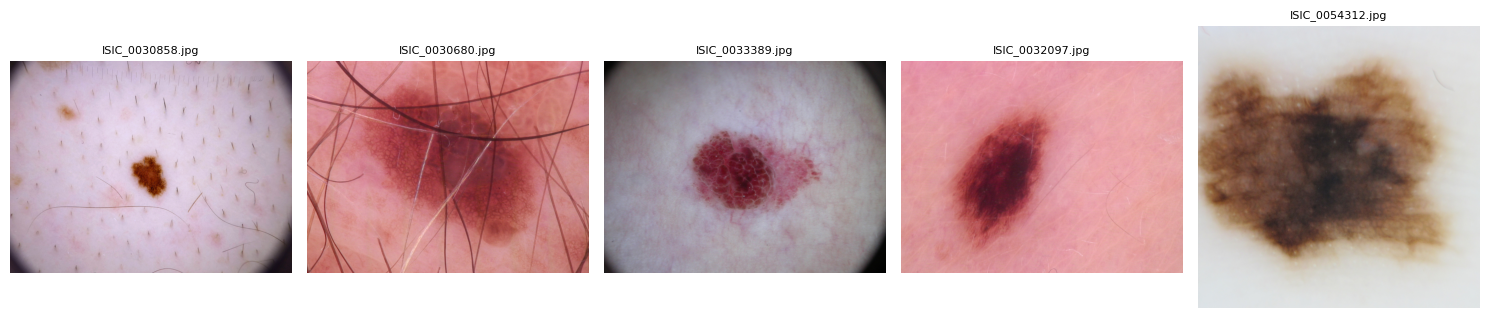

In [10]:
# === Check Images from ISIC 2019 ===
# List only .jpg image files (ignore folders)
isic_files = [f for f in os.listdir(isic_folder) if f.endswith('.jpg') and os.path.isfile(os.path.join(isic_folder, f))]

print("ISIC 2019 images")
print("Total .jpg files found:", len(isic_files))
print("Sample image names:", isic_files[:5])

# === Visualize First 5 Images ===
print("\nImages before preprocessing:")
view_images(isic_folder, 5)


HAM10000 Part 1 images
Total .jpg files found: 5000
Sample image names: ['ISIC_0026784.jpg', 'ISIC_0028971.jpg', 'ISIC_0026948.jpg', 'ISIC_0026790.jpg', 'ISIC_0028965.jpg']

Images before preprocessing:


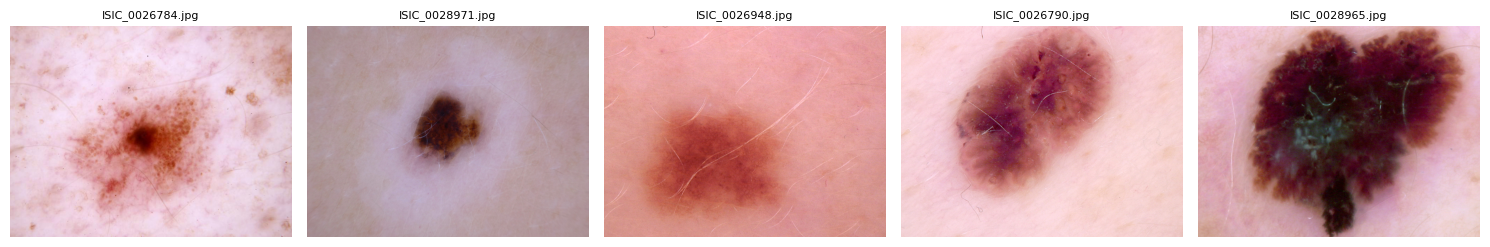


HAM10000 Part 2 images
Total .jpg files found: 5015
Sample image names: ['ISIC_0030858.jpg', 'ISIC_0030680.jpg', 'ISIC_0033389.jpg', 'ISIC_0032097.jpg', 'ISIC_0032929.jpg']

Images before preprocessing:


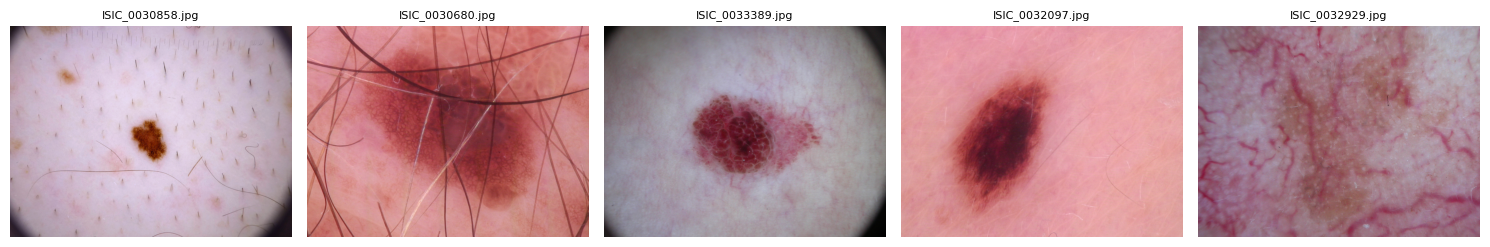

In [11]:
# === Check Images from HAM10000 Part 1 ===
# List only .jpg image files (ignore folders)
ham_files_1 = [f for f in os.listdir(ham_folder_1) if f.endswith('.jpg') and os.path.isfile(os.path.join(ham_folder_1, f))]

print("\nHAM10000 Part 1 images")
print("Total .jpg files found:", len(ham_files_1))
print("Sample image names:", ham_files_1[:5])

# === Visualize First 5 Images ===
print("\nImages before preprocessing:")
view_images(ham_folder_1, 5)


# === Check Images from HAM10000 Part 2 ===
# List only .jpg image files (ignore folders)
ham_files_2 = [f for f in os.listdir(ham_folder_2) if f.endswith('.jpg') and os.path.isfile(os.path.join(ham_folder_2, f))]

print("\nHAM10000 Part 2 images")
print("Total .jpg files found:", len(ham_files_2))
print("Sample image names:", ham_files_2[:5])

# === Visualize First 5 Images ===
print("\nImages before preprocessing:")
view_images(ham_folder_2, 5)

#### Filter All Images

In [ ]:
# === Filtering ISIC 2019 Images ===
print("\nFiltering ISIC 2019 images...")
filter_all_images(isic_folder, output_folder)


Filtering ISIC 2019 images...
Processing ISIC_0030858.jpg...
Processing ISIC_0030680.jpg...
Processing ISIC_0033389.jpg...
Processing ISIC_0032097.jpg...
Processing ISIC_0054312.jpg...
Processing ISIC_0062878.jpg...
Processing ISIC_0032929.jpg...
Processing ISIC_0069093.jpg...
Processing ISIC_0056263.jpg...
Processing ISIC_0010236.jpg...
Processing ISIC_0011128.jpg...
Processing ISIC_0026784.jpg...
Processing ISIC_0028971.jpg...
Processing ISIC_0026948.jpg...
Processing ISIC_0069087.jpg...
Processing ISIC_0010222.jpg...
Processing ISIC_0059144.jpg...
Processing ISIC_0026790.jpg...
Processing ISIC_0057169.jpg...
Processing ISIC_0068399.jpg...
Processing ISIC_0028965.jpg...
Processing ISIC_0065865.jpg...
Processing ISIC_0025299.jpg...
Processing ISIC_0016009_downsampled.jpg...
Processing ISIC_0032083.jpg...
Processing ISIC_0054306.jpg...
Processing ISIC_0053469.jpg...
Processing ISIC_0024839.jpg...
Processing ISIC_0069939.jpg...
Processing ISIC_0056511.jpg...
Processing ISIC_0067914.jpg

In [ ]:
# === Filtering HAM10000 Images ===
print("\nFiltering HAM10000 Part 1 images...")
filter_all_images(ham_folder_1, output_folder)
print("\nFiltering HAM10000 Part 2 images...")
filter_all_images(ham_folder_2, output_folder)

In [ ]:
# === View Filtered Images ===
print("Images after filtering:")
view_images(output_folder, 5)

#### Load Data Frames

In [ ]:
# === Load Labels CSV ===
isic_df = pd.read_csv(isic_labels_path)[['image', 'MEL']]
print("\nISIC 2019 labels preview:")
print(isic_df.head())

print("Renaming columns and adding path...")
isic_df.rename(columns={'image': 'image_name', 'MEL': 'melanoma'}, inplace=True)
isic_df['path'] = isic_df['image_name'].apply(lambda file_name: os.path.join(output_folder, f"{file_name}.jpg"))
print(isic_df.head())

# === Melanoma vs. Non-Melanoma ===
num_melanoma(isic_df)  # Display the number of melanoma vs non-melanoma images

In [ ]:
# === Load Labels CSV ===
ham_df = pd.read_csv(ham_labels_path)[['image_id', 'dx']]
print("\HAM10000 labels preview:")
print(ham_df.head())

print("Renaming columns, adding one-hot encoding, and adding path...")
ham_df.rename(columns={'image_id': 'image_name', 'dx': 'melanoma'}, inplace=True)
ham_df['melanoma'] = ham_df['melanoma'].apply(lambda x: 1 if x == 'mel' else 0)  # Convert to binary
ham_df['path'] = ham_df['image_name'].apply(lambda file_name: os.path.join(output_folder, f"{file_name}.jpg"))
print(ham_df.head())

# === Melanoma vs. Non-Melanoma ===
num_melanoma(ham_df)  # Display the number of melanoma vs non-melanoma images

In [ ]:
# === Combine ISIC and HAM10000 DataFrames ===
# Combine the two DataFrames and if the image name is the same, keep only one entry
combined_df = pd.concat([isic_df, ham_df], ignore_index=True)
combined_df.drop_duplicates(subset=['image_name'], keep='first', inplace=True)
print("\nCombined DataFrame preview:")
print(combined_df.head())
print("Total images in combined DataFrame:", len(combined_df))

# Save the combined DataFrame to CSV
combined_df.to_csv(output_csv_path, index=False)
print(f"Combined DataFrame saved to {output_csv_path}")

#### Data Augmentation

In [ ]:
print("\nApplying data augmentation to balance the dataset...")
combined_df = oversample_melanoma_images(output_folder, combined_df, output_csv_path)

#### Preview Augmented Dataset

In [ ]:
print("\nBalanced dataset preview:")
print(combined_df.head())
num_melanoma(combined_df)  # Display the number of melanoma vs non-melanoma images